# 巡线算法详解与调参指南

## 概要
本文详解讲解了双足机器人巡线例程的图像处理流程, 同时本文档也兼具了调参指导手册的功能. 因为只有了解图像处理的流程, 才能够明确要调节哪些参数.

## 技术难点
在讲解具体的算法之前, 先列举一下潜在的问题,在后文中,会介绍如何对下列的难点做针对性处理.

1. 广告布容易反光, 容易形成亮斑.如果斑块恰好在黑线上, 就会导致曲线不连惯.
   另外亮斑本身也会给阈值分割带来干扰.
2. 广告布本身是有密集的网格状的纹理, 对阈值分割也是噪声.
3. 环境光线强度不可控, 场地大, 全局阈值分割效果不好.
   机器人本身的影子会映在白色区域.
4. 机器人在边缘处, 容易看到赛道之外的东西(例如地板等)
5. 当画面中曲率比较大或者复杂的时候, 没办法用单个二次曲线去拟合. 可能会得到无意义的曲线.
6. 如何根据斜率与偏移量指导机器人执行不同的动作.
7. 镜头视场角如果比较大的话,容易收到周围其他物体的干扰, 而且鱼眼镜头(例如185度视场角),不满足小孔成像模型, 不能够应用透视逆变换算法. 
   视场角小了, 直线容易丢失(尤其是在拐角处).
   
## 图像处理的配置参数

图像预处理以及赛道曲线拟合都是在`cv_track_fit.py`里面的`TrackFit`类里面实现的.

配置参数,都放置在类的起始位置, 用大写表示


`cv_track_fit.py`代码片段
```python
class TrackFit:
    '''赛道曲线拟合'''
    # 图像缩放因子
    IMG_SCALE_FACTOR = 0.05 
    # 赛道颜色阈值(白底+黑线 两个阈值的并集)
    # 这个阈值的作用是防止除了赛道之外的颜色干扰, 例如地毯, 地板等
    # 晚上的阈值
    # TRACK_HSV_LOWERB = (17, 0, 0) # 阈值下界
    # TRACK_HSV_UPPERB = (120, 26, 255) # 阈值上界
    TRACK_HSV_LOWERB = (0, 0, 0)
    TRACK_HSV_UPPERB = (255, 255, 255)
    # 色块的最小连通区域面积(针对32x24的缩略图)
    MIN_CNT_AREA = 25 # 最小的连通区域的面积(针对缩放之后的图像)
    # 机器人坐标系下点的取值范围
    # 机器人只关注这个范围下的点
    RB_Y_MIN = -30
    RB_Y_MAX = 30
    RB_X_MIN = 5
    RB_X_MAX = 50
    # 滑动窗口
    WIN_W = 6 # 滑动窗口的宽度
    WIN_H = 1 # 滑动窗口的高度
    WIN_MAX_GAP = 5 # 采样点轴方向最大的间隙(距离)
    # 曲线1的尾巴采样窗口, 决定曲线2的滑动窗口采样方向
    # 是沿着Y轴的正方向还是沿着Y轴的负方向
    TAIL_ROI_W = 10
    TAIL_ROI_H = 20
    # 曲线1尾巴采样框内, 未采样到的样本点的个数
    # 决定是否要进行曲线2的采样
    TAIL_ROI_MIN_PT = 4
    # 曲线2的采样方向
    # 向下采样还是向上采样
    DIR_Y_POSI = 0 # 向Y轴的正方向采样
    DIR_Y_NEGI = 1 # 向Y轴的负方向采样
    # 轨道灰度值的最大值(大于这个值的都设置为最大值))
    TRACK_GRAY_MAX = 180
    # 直线灰度的最大值 (仅当做判断当前画面是否有直线使用)
    LINE_GRAY_MAX = 120
    # 在 32x24缩略图中, 直线像素的点(满足像素灰度小于LINE_GRAY_MAX)
    # 的个数的最小值, 如果大于这个值,就认为画面中有直线,否则不予处理.
    LINE_PIXEL_N_MIN = 40
    # 合法的曲线的长度(单位cm)
    # 如果拟合得到的曲线比自身宽度还要小的话是没有意义的
    CURVE_MIN_LEN = 4 # 曲线的最小的长度
    # 机器人前进一步的距离(单位cm)
    RB_STEP = 10
    # 曲线可视化的绘图引擎
    PAINTER = 'CV' # 可选绘图引擎是"Matplotlib"跟 "CV"
                    # Matplotlib绘图质量好但是帧率差
```

## 导入依赖

In [1]:
from cv_camera import Camera

In [2]:
from config import CAM_PORT_NAME

图像处理相关的脚本是`cv_track_fit.py`.

在本文中, 会引入该文件, 逐步演示图像处理的过程.

In [3]:
from cv_track_fit import TrackFit

因为涉及到图像显示与可视化绘制, 这里需要导入matplotlib

In [4]:
from matplotlib import pyplot as plt

需要用到图像处理,图像读取, 导入opencv

In [5]:
import cv2

In [6]:
import numpy as np

## 导入原始图像

在`data/image_raw`文件夹下存放了一些采集到的原始图像. 

你也可以使用`cv_camera.py`脚本, 自己采集一些图像, 存储在`data/image_raw`文件夹下.

![](./image/image_raw.png)

导入一张拐角比较大的图像

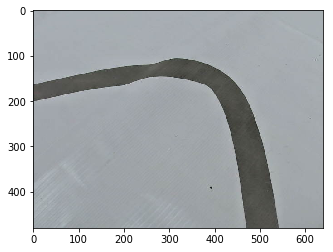

In [7]:
img_raw = cv2.imread('data/image_raw/1.png')

plt.imshow(img_raw[:,:,::-1])

## 创建轨道拟合对象

In [8]:
# 创建一个Camera对象
cam = Camera(CAM_PORT_NAME)
# 载入标定参数
cam.load_cam_calib_data()
# 载入IPM映射矩阵
cam.load_ipm_remap()

计算IPM映射矩阵, 并存储在 config/ipm_remap.bin
更新完成


In [9]:
# 创建轨道拟合对象
trk_fit = TrackFit(cam)

## 图像预处理

使用`TrackFit.img_preprocess`函数完成图像预处理.

In [10]:
has_line, gray_small, bin_track, bin_ostu, bin_line = trk_fit.img_preprocess(img_raw)

In [11]:
print('画面中是否有直线: has_line={}'.format(has_line))

画面中是否有直线: has_line=True


>  难点1: 广告布容易反光, 容易形成亮斑.如果斑块恰好在黑线上, 就会导致曲线不连惯.
   另外亮斑本身也会给阈值分割带来干扰.
   
>  难点2. 广告布本身是有密集的网格状的纹理, 对阈值分割也是噪声.

将原图转换为灰度图,然后使用**高斯滤波**, 过滤掉广告布本身的纹理细节,以及局部的小亮点(反光点)

原图像是640x480的,对原图像进行缩放,一方面可以降低计算量, 减少图像处理所需的时间. 
另外一方面, 可以有效解决小亮斑引起的曲线不连贯的问题. 为后续做数学形态学处理提供方便.

通过修改参数`IMG_SCALE_FACTOR`，可以修改图像缩放的比例. 经实验在4cm线宽的应用场景下,缩放比例设置为`0.05`, 即缩小20倍, 可以获得比较好的效果.


*代码片段*
```python
# 彩图转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 高斯滤波,过滤掉广告布本身的纹理细节,以及局部的小亮点(反光点)
gray = cv2.GaussianBlur(gray, (5, 5), sigmaX=1)
# 将灰度图进行缩放
gray_small = cv2.resize(gray, dsize=None,\
                        fx=self.IMG_SCALE_FACTOR ,
                        fy=self.IMG_SCALE_FACTOR)
```

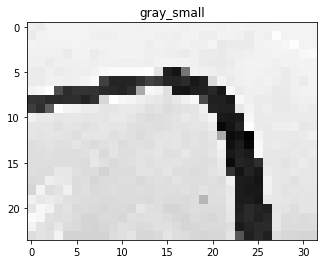

In [12]:
plt.title('gray_small')
plt.imshow(gray_small, cmap='gray')


> 难点4. 机器人在边缘处, 容易看到赛道之外的东西(例如地板等)

处理这种情况,需要根据赛道所铺设的场地进行设置. 假定有一个HSV的颜色阈值,可以将黑线与白色背景筛选出来, 
其他的颜色(例如黄色的地板,带颜色的部分可以通过饱和度进行筛选)都可以被排除掉.

赛道(track)颜色阈值相关的配置参数.
```python
# 赛道颜色阈值(白底+黑线 两个阈值的并集)
# 这个阈值的作用是防止除了赛道之外的颜色干扰, 例如地毯, 地板等
# 晚上的阈值
# TRACK_HSV_LOWERB = (17, 0, 0) # 阈值下界
# TRACK_HSV_UPPERB = (120, 26, 255) # 阈值上界
TRACK_HSV_LOWERB = (0, 0, 0)
TRACK_HSV_UPPERB = (255, 255, 255)
```

**工程里面只是保留了这个接口, 可以不设置. 当然也可能是因为添加了这个固定的阈值, 让识别的效果变得更差了.
只有当底板的颜色跟黑色从灰度图上很难区分的时候, 才需要启用次功能.**
更好的办法, 是给黑线的四周留有足够的空白．


对BGR色彩空间的彩图, 进行缩放得到`img_small_bgr`.让后将其转换为HSV色彩空间,得到`img_small_hsv`.
通过全局阈值获取到`bin_track`.
得到的`bin_track`可能会有一些空洞, 所以对其进行闭运算.

*代码片段*
```python
# 将彩图缩放为小图
img_small_bgr = cv2.resize(img, dsize=None, fx=self.IMG_SCALE_FACTOR, fy=self.IMG_SCALE_FACTOR)
# 转换为HSV色彩空间
img_small_hsv = cv2.cvtColor(img_small_bgr, cv2.COLOR_BGR2HSV)
# 对彩色缩放图进行二值化,过滤掉除了黑色跟白色之外的其他颜色的背景
bin_track = cv2.inRange(img_small_hsv, lowerb=self.TRACK_HSV_LOWERB, upperb=self.TRACK_HSV_UPPERB)
# 对二值化图像进行闭运算
bin_track = cv2.morphologyEx(bin_track, cv2.MORPH_CLOSE,\
    np.ones((3,3), np.uint8) ,iterations=1)
```

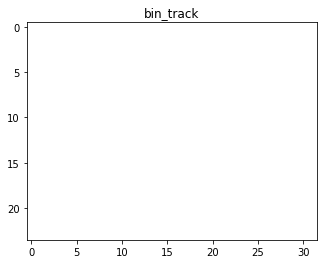

In [13]:
plt.title('bin_track')
plt.imshow(cv2.cvtColor(bin_track,cv2.COLOR_GRAY2RGB))

接下来通过图像`gray_small`中满足黑线灰度要求的像素点的个数判断画面中是否有黑线.
相关的配置参数是 `LINE_GRAY_MAX=120`, 以及`LINE_PIXEL_N_MIN=40`.
如果在灰度图中,该点像素值小于`LINE_GRAY_MAX`, 就认为这个点为黑线上点.
另外如果这个缩略图中所有小于阈值的像素加在一起小于`LINE_PIXEL_N_MIN`个，那么就认为画面中没有曲线．

添加这个设置之后, 可以有效过滤掉非黑线的其他背景的干扰. 

*代码片段*
```python
# 通过像素统计判断是否存在直线
blk_pt_n = np.sum(gray_small < self.LINE_GRAY_MAX)
if blk_pt_n < self.LINE_PIXEL_N_MIN:
    # print('黑色的像素点个数：{} 小于阈值'.format(blk_pt_n))
    bin_track = np.uint8(np.uint8(gray_small > self.LINE_GRAY_MAX) * 255)
    bin_ostu = cv2.bitwise_not(bin_track)
    bin_line = bin_ostu
    return False, gray_small, bin_track, bin_ostu, bin_line
```

> 难点1. 广告布容易反光, 容易形成亮斑.如果斑块恰好在黑线上, 就会导致曲线不连惯.
   另外亮斑本身也会给阈值分割带来干扰.

针对光斑对阈值分割算法(OSTU)导致的干扰, 另外的一个优化就是限制灰度图`gray_small`中的最大值.　这样做有助于规避强光引起的OSTU阈值的错误．　但是这样也会带来灰度图上不必要的梯度变化. 通过补光灯可以减弱此操作带来的梯度变化.

*代码片段*
```python
gray_small[gray_small > self.TRACK_GRAY_MAX] = self.TRACK_GRAY_MAX
```

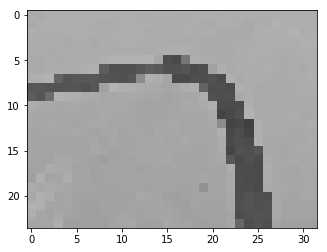

In [14]:
# 真实的gray_small的RGB图
plt.imshow(cv2.cvtColor(gray_small,cv2.COLOR_GRAY2RGB))

接下来要通过大津算法选自适应阈值(OSTU)对gray_small进行二值化运算, 获得黑线的二值化图像.

然后再进行一下闭运算，消除连通域内的孔洞.
```python
# 对缩小的图进行自适应阈值
ret, bin_ostu = cv2.threshold(gray_small, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# print('OSTU Binary Ret: {}'.format(ret))
# 对二值化图像进行闭运算
bin_ostu = cv2.morphologyEx(bin_ostu, cv2.MORPH_CLOSE,\
    np.ones((3,3), np.uint8) ,iterations=1)
```

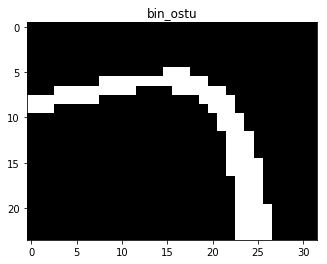

In [15]:
plt.title('bin_ostu')
plt.imshow(bin_ostu, cmap='gray')

综合`bin_track`跟`bin_ostu`，二值化图像进行与操作, 获得在赛道区域内的黑线的二值化图像`bin_line`
之后筛选掉面积小于`MIN_CNT_AREA`的连通域．

*代码片段*
```python
# 综合赛道的二值化图像还有曲线的二值化图像
# 过滤掉非赛道区域的像素
bin_line = np.bitwise_and(bin_ostu, bin_track) # 直线的二值化图像
# bin_line = bin_ostu
# 过滤掉较小的连通区域
line_cnts = self.find_contours(bin_line) # 寻找连通域
valid_cnt_num = 0
if len(line_cnts) >= 1:
    # 筛选面积大于阈值的连通域
    bin_line = np.zeros_like(bin_line)
    for cnt in line_cnts:
        if cv2.contourArea(cnt) > self.MIN_CNT_AREA:
            valid_cnt_num += 1
            bin_line = cv2.drawContours(image=bin_line, contours=[cnt], contourIdx=0, color=255, thickness=-1)

# 判断画面中是否有直线的区域
has_line = valid_cnt_num > 0
```


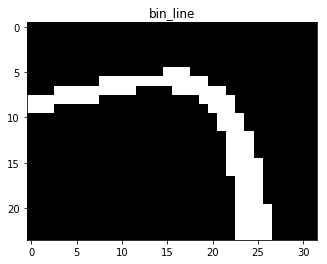

In [16]:
plt.title('bin_line')
plt.imshow(bin_line, cmap='gray')

## 透视逆变换

通过透视逆变换, 将缩略图的黑线二值化图像上的像素点恢复到原图像的范围(640x480), 然后通过透视逆变换投影在机器人坐标系下.

In [17]:
canvas_img = np.copy(img_raw)
# 透视逆变换
rb_x, rb_y = trk_fit.pixel_ipm(bin_line, canvas=canvas_img)

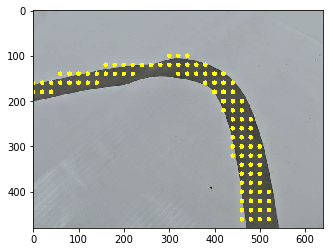

In [18]:
plt.imshow(cv2.cvtColor(canvas_img,cv2.COLOR_BGR2RGB))

图像中的黄点就是缩略图投影在原图像上的点.

机器人坐标系下黑线采样点的x坐标 :`rb_x`

机器人坐标系下黑线采样点的y坐标:`rb_y`

## 曲线拟合

使用`curve_fit`函数进行曲线拟合

<Figure size 576x432 with 0 Axes>

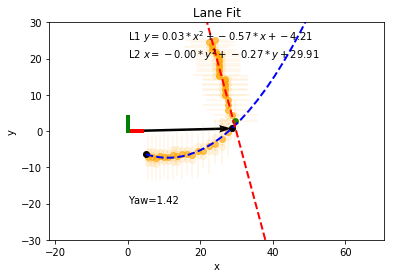

In [21]:
# 使用Matplot绘制高清晰度的图像
trk_fit.PAINTER = 'MATPLOTLIB'
trk_fit.set_painter()
# 曲线拟合与图像绘制
has_c1, has_c2, next_yaw, cross_ab, canvas_robo = trk_fit.curve_fit(rb_x, rb_y, is_draw=True)

In [28]:
print('曲线1是否存在 has_c1: {}'.format(has_c1))
print('曲线2是否存在 has_c2: {}'.format(has_c2))
print('目标偏航角 next_yaw: {:.1f} 度'.format(next_yaw))
print('向量A跟向量B叉乘的结果 cross_ab: {:.1f}'.format(cross_ab))

曲线1是否存在 has_c1: True
曲线2是否存在 has_c2: True
目标偏航角 next_yaw: 1.4 度
向量A跟向量B叉乘的结果 cross_ab: 675.3


> 难点5. 当画面中曲率比较大或者复杂的时候, 没办法用单个二次曲线去拟合. 可能会得到无意义的曲线.

因为可能会出现弯道转弯幅度比较大的情况, 所以算法采用两条二次曲线进行拟合. 

曲线1(图中的蓝线)的自变量为x坐标, 因变量为y

曲线2(图中的红线)的自变量为y坐标，因变量为x

使用滑动窗口对机器人坐标系下的点进行采样, 滑动窗口的尺寸为`WIN_W*WIN_H`

```python
# 滑动窗口
WIN_W = 6 # 滑动窗口的宽度
WIN_H = 1 # 滑动窗口的高度
```

曲线1优先进行采样, 从样本点的x坐标最小值开始,一直向x正方向滑动.
等到滑动窗口找不到样本点的时候就停下.
> 注: 算法实现细节见`c1_pt_sample`函数.




曲线1采样点的最后一个点(上图中的绿点, 两个二次曲线的交汇点)为中心的矩形区域,尺寸为`TAIL_ROI_W*TAIL_ROI_H`

```python
# 曲线1的尾巴采样窗口, 决定曲线2的滑动窗口采样方向
# 是沿着Y轴的正方向还是沿着Y轴的负方向
TAIL_ROI_W = 10
TAIL_ROI_H = 20
```
判断矩形区域内的未被访问的像素点的个数是否大于`TAIL_ROI_MIN_PT`, 若大于`TAIL_ROI_MIN_PT`则认为存在曲线2. 同时根据未被采样点的上下分布情况, 判断是向y轴的正方向滑动还是负方向滑动. 详情见`has_curve2`函数.

接下来用类似的方法,使用滑动窗口对曲线2上的点进行采样. 
之后分别对曲线1跟曲线2进行拟合.

最后,分别统计曲线1跟曲线2的长度, 如果长度小于`CURVE_MIN_LEN`也会被认为该曲线不存在

> 难点6. 如何根据斜率与偏移量指导机器人执行不同的动作.

这个相对来讲比较好处理, 假设曲线1存在, 遍历在视野范围内的二次曲线上点, 找到一个点距离机器人坐标系距离最近的点. 把这个点当做成机器人在这个曲线上的位置(存在一定程度的偏移量). 然后顺着这条曲线, 找到机器人前进一步`RB_STEP=10`的后继点的x坐标, 将这个新的x坐标带入到二次曲线的函数里面,就可以得到这个**后继点**的坐标, 如图中黑色箭头所示.

然后根据这个箭头,计算目标偏航角`next_yaw`.